In [4]:
import sys
sys.path.append('../../..')
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os
import numpy as np
import xarray as xr
import random as rd
import platform
import adamod
import torch
import torch.nn.functional as F


from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from utils.dataset import NCDFDatasets
from utils.trainer import Tester
from utils.trainer import Trainer
from datetime import datetime
from evonorm import EvoNorm3D

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if (torch.cuda.is_available()):
    torch.cuda.empty_cache()
device

device(type='cuda', index=0)

In [7]:
batch_size = 25
validation_split = 0.2
test_split = 0.2
dropout_rate = 0.2
hidden_size = 32*32
mogrify_rounds = 5
param = {'encoder_layer_size': 3, 'decoder_layer_size': 3, 'kernel_size': 5, 'filter_size': 32}
weights = [0.9, 0.1]

In [8]:
seed = 1000
np.random.seed(seed)
rd.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def init_seed(seed):
    np.random.seed(seed)
    
init_seed = init_seed(seed)

In [9]:
import xarray as xr
data_path = '/content/drive/My Drive/Colab Notebooks/dataset-ucar-1979-2015-seq5-ystep5.nc'
dataset = xr.open_dataset(data_path)
print(dataset)

<xarray.Dataset>
Dimensions:  (channel: 1, lat: 32, lon: 32, sample: 54047, time: 5)
Coordinates:
  * lat      (lat) int32 -54 -52 -50 -48 -46 -44 -42 -40 ... -6 -4 -2 0 2 4 6 8
  * lon      (lon) int32 278 280 282 284 286 288 290 ... 330 332 334 336 338 340
Dimensions without coordinates: channel, sample, time
Data variables:
    x        (sample, time, lat, lon, channel) float32 ...
    y        (sample, time, lat, lon, channel) float32 ...
Attributes:
    description:  The variables have air temperature values and are separable...


In [10]:
#In these experiments y has dimensions [batch, channel, lat, lon] as opposed to [batch, channel, time, lat, lon] to
#avoid dimension conflict with conv kernels
data = NCDFDatasets(dataset, val_split = 0.2, test_split = 0.2,  data_type='Reconstruction')
train_data = data.get_train()
val_data = data.get_val()
test_data = data.get_test()

In [11]:
print("-----Train-----")
print("X : ", train_data.x.shape)
print("Y : ", train_data.y.shape)
print("Removed : ", train_data.removed.shape)
print("-----Val-----")
print("X : ", val_data.x.shape)
print("Y : ", val_data.y.shape)
print("Removed : ", val_data.removed.shape)
print("-----Test-----")
print("X : ", test_data.x.shape)
print("Y : ", test_data.y.shape)
print("Removed : ", test_data.removed.shape)

-----Train-----
X :  torch.Size([32429, 1, 10, 32, 32])
Y :  torch.Size([32429, 1, 10, 32, 32])
Removed :  torch.Size([32429])
-----Val-----
X :  torch.Size([10809, 1, 10, 32, 32])
Y :  torch.Size([10809, 1, 10, 32, 32])
Removed :  torch.Size([10809])
-----Test-----
X :  torch.Size([10809, 1, 10, 32, 32])
Y :  torch.Size([10809, 1, 10, 32, 32])
Removed :  torch.Size([10809])


In [12]:
params = {'batch_size': batch_size,
          'num_workers': 4,
          'worker_init_fn': init_seed}

train_loader = DataLoader(dataset=train_data, shuffle=True, **params)
val_loader = DataLoader(dataset=val_data, shuffle=False, **params)
test_loader = DataLoader(dataset=test_data, shuffle=False, **params)

In [13]:
class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [14]:
class CustomConv3d(torch.nn.Conv3d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1,
                 bias=False, padding_mode='zeros', weight=None):
        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                 padding=padding, dilation=dilation,
                 bias=bias, padding_mode=padding_mode)
        
    def forward(self,input, weight=None):
        if (weight is not None):
            return F.conv3d(input, weight.permute(1,0,2,3,4), self.bias, self.stride,
                        self.padding, self.dilation)
        else:
            return F.conv3d(input, self.weight, self.bias, self.stride,
                        self.padding, self.dilation)

In [15]:
class EncoderCNN(torch.nn.Module):
    def __init__(self, layer_size, kernel_size, initial_out_channels, initial_in_channels, device):
        super(EncoderCNN, self).__init__()
        self.device = device
        self.layer_size = layer_size
        self.conv_layers = torch.nn.ModuleList()
        #self.mish_layers = torch.nn.ModuleList()
        self.bn_layers = torch.nn.ModuleList()
        self.decode_bn_layers = torch.nn.ModuleList()
        #self.dropout_layers = torch.nn.ModuleList()
        
        self.kernel_size = [1, kernel_size, kernel_size]
        self.padding = [0, kernel_size // 2, kernel_size // 2]
        
        in_channels = initial_in_channels
        out_channels = initial_out_channels
        for i in range(self.layer_size):
            self.conv_layers.append(CustomConv3d(in_channels = in_channels, out_channels = out_channels,
                                                padding = self.padding, kernel_size = self.kernel_size))
            #self.mish_layers.append(Mish())
            self.bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            self.decode_bn_layers.append(EvoNorm3D(out_channels, version = 'B0_3D'))
            #self.dropout_layers.append(torch.nn.Dropout(dropout_rate))
            in_channels = out_channels
        self.conv_reduce = CustomConv3d(in_channels = in_channels, out_channels = 1,
                                                kernel_size = 1)
            
            
    def forward(self, x, decode=False):#, x_rev=None):
        if (decode):
            x = self.conv_reduce(x, self.conv_reduce.weight)
            #if (x_rev is not None):
              #x_rev = self.conv_reduce(x_rev, self.conv_reduce.weight)
              #x = (x + x_rev) / 2
            for i in range(self.layer_size-1, -1, -1):
                x = self.decode_bn_layers[i](x)
                #x = self.dropout_layers[i](x)
                x = self.conv_layers[i](x, self.conv_layers[i].weight)
        else:
            for i in range(self.layer_size):
                x = self.conv_layers[i](x)
                x = self.bn_layers[i](x)
                #x = self.dropout_layers[i](x)
            x = self.conv_reduce(x)
        return x

In [16]:
class STModel(torch.nn.Module):
    def __init__(self, encoder_layer_size, kernel_size, out_channels, in_channels, input_width, input_height, hidden_size
                 , device):
        super(STModel, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.encoder_fwd = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, device=device)
        self.encoder_bckwd = EncoderCNN(layer_size = encoder_layer_size, kernel_size = kernel_size,
                                initial_out_channels = out_channels,
                                initial_in_channels = in_channels, device=device)
        self.recurrent_forward = torch.nn.LSTMCell(input_width*input_height, hidden_size);
        self.recurrent_backward = torch.nn.LSTMCell(input_width*input_height, hidden_size);
       
        
    def forward(self, x, states_fwd, states_bckwd, removed):
        batch, channel, time, lat, lon = x.size()
        x_rev = torch.flip(x, [2])
        x_fwd = self.encoder_fwd(x)
        x_bckwd = self.encoder_bckwd(x_rev)
        
        x_fwd = x_fwd.squeeze().view(batch, time, -1)
        x_bckwd = x_bckwd.squeeze().view(batch, time, -1)


        h_fwd = states_fwd[0]
        c_fwd = states_fwd[1]
        h_bckwd = states_bckwd[0]
        c_bckwd = states_bckwd[1]
        
        outputs_fwd = torch.zeros(batch, time, lat*lon, device=self.device)
        outputs_bckwd = torch.zeros(batch, time, lat*lon, device=self.device)

        for i in range(time):
            h_fwd, c_fwd = self.recurrent_forward(x_fwd[:,i,:],(h_fwd,c_fwd))
            outputs_fwd[:,i,:] = h_fwd
            
            h_bckwd, c_bckwd = self.recurrent_backward(x_bckwd[:,i,:], (h_bckwd,c_bckwd))
            outputs_bckwd[:,i,:] = h_bckwd


        x_fwd = outputs_fwd.contiguous().view(batch, channel, time, lat, lon)
        x_bckwd = outputs_bckwd.contiguous().view(batch, channel, time, lat, lon)

        x_fwd = self.encoder_fwd(x_fwd, decode=True)
        x_bckwd = self.encoder_bckwd(x_bckwd, decode=True)

        x_bckwd = torch.flip(x_bckwd, [2])
        x = (x_fwd + x_bckwd) / 2

        return x
        

In [17]:
class WeightedRMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    '''def forward(self,y,yhat, removed):
        #y : 25 x ch x time x lat x lon
        #removed : 25
        batch, ch, time, lat, lon = yhat.shape
        cumulative_loss = 0
        for i in range(batch):
            cumulative_loss += self.mse(y[i,:,removed[i],:,:],  yhat[i,:,removed[i],:,:])
        return torch.sqrt((cumulative_loss / (batch))+ self.eps)'''
    def forward(self,yhat,y, removed):
        #y : 25 x ch x time x lat x lon
        #removed : 25
        batch, ch, time, lat, lon = yhat.shape
        cumulative_loss = 0
        for i in range(batch):
            for j in range(time):
                weight = weights[0] if removed[i] == j else (weights[1]/(time-1))
                cumulative_loss += self.mse(yhat[i,:,j,:,:], y[i,:,j,:,:]) * weight
        return torch.sqrt((cumulative_loss / (batch))+ self.eps)


In [18]:
model = STModel(encoder_layer_size = param['encoder_layer_size'], kernel_size = param['kernel_size'], out_channels = param['filter_size'],
                in_channels = train_data.x.shape[1], input_width = train_data.x.shape[3], 
                input_height = train_data.x.shape[4], hidden_size = hidden_size, device=device).to(device)
criterion = WeightedRMSELoss()
#optimizer_params = {'lr': 0.001}
#optimizer = torch.optim.Adam(net.parameters(), **optimizer_params)
opt_params = {'lr': 0.001, 
              'beta3': 0.999}
optimizer = adamod.AdaMod(model.parameters(), **opt_params)
model

STModel(
  (encoder_fwd): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv3d(1, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
      (1): CustomConv3d(32, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
      (2): CustomConv3d(32, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
    )
    (bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (decode_bn_layers): ModuleList(
      (0): EvoNorm3D()
      (1): EvoNorm3D()
      (2): EvoNorm3D()
    )
    (conv_reduce): CustomConv3d(32, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
  )
  (encoder_bckwd): EncoderCNN(
    (conv_layers): ModuleList(
      (0): CustomConv3d(1, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
      (1): CustomConv3d(32, 32, kernel_size=[1, 5, 5], stride=(1, 1, 1), padding=[0, 2, 2], bias=False)
      (2): CustomConv3d(32, 32, ke

In [19]:
model_path = os.path.join('ST-RFD-EvoNormB03D' + '_' + datetime.now().strftime('m%md%d-h%Hm%Ms%S') + '.pth.tar')
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, 100, device, model_path, recurrent_model= True, is_reconstruction=True)


In [ ]:
train_losses, val_losses = trainer.train_evaluate()

Train - Epoch 0, Epoch Loss: 2.270311
Val Avg. Loss: 1.957585
=> Saving a new best
Train - Epoch 1, Epoch Loss: 1.586620
Val Avg. Loss: 1.808128
=> Saving a new best
Train - Epoch 2, Epoch Loss: 1.470577
Val Avg. Loss: 1.512345
=> Saving a new best
Train - Epoch 3, Epoch Loss: 1.385641
Val Avg. Loss: 1.354613
=> Saving a new best
Train - Epoch 4, Epoch Loss: 1.310584
Val Avg. Loss: 1.321224
=> Saving a new best
Train - Epoch 5, Epoch Loss: 1.226162
Val Avg. Loss: 1.402413


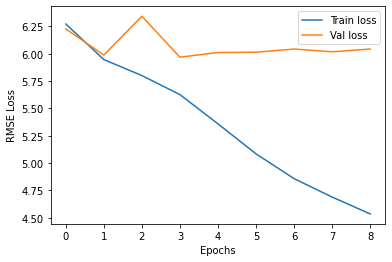

In [ ]:
epochs = np.arange(1,len(val_losses))
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")
plt.show()

In [ ]:

model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
with torch.no_grad():
    for i, (x, y, removed) in enumerate(test_loader):
        x,y,removed = x.to(device), y.to(device), removed.to(device)
        output = model(x)
        loss = criterion(output, y, removed)
        batch_test_loss += loss.detach().item()
test_loss = batch_test_loss/len(test_loader)
loss_type = type(criterion).__name__
print(f'STConvS2S {loss_type}: {test_loss:.4f}')

In [ ]:
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss = 0.0
model.eval()
previous_three_steps = []

with torch.no_grad():
    for i, (x, y, removed) in enumerate(test_loader):
        x,y,removed = x.to(device), y.to(device), removed.to(device)
        ground_truth = y[19,0,:,:,:]
        output = model(x)
        prediction = output[19,0,:,:]
        print(criterion(output, y, removed))
        break

tensor(0.9107, device='cuda:0')


tensor([[[0., 0., 0.,  ..., -0., -0., -0.],
         [0., 0., 0.,  ..., -0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor([[[ 3.8500,  4.6500,  5.1500,  ..., -1.8500, -1.6500, -0.1500],
         [ 4.1500,  4.7500,  5.5500,  ..., -0.4500,  0.3500,  0.8500],
         [ 3.9500,  4.9500,  6.2500,  ...,  0.1500,  1.3500,  1.8500],
         ...,
         [25.7500, 26.1500, 26.8500,  ..., 25.6500, 25.2500, 24.7500],
         [26.6500, 26.4500, 25.9500,  ..., 25.1500, 25.4500, 25.5500],
         [27.5500, 28.2500, 26.7500,  ..., 25.1500, 25.6500, 25.0500]]],
       device='cuda:0')
tensor([[[ 3.3512,  3.9666,  4.4426,  ..., -1.6286, -0.8799, -0.0664],
         [ 4.0977,  4.6328,  5.7899,  ..., -0.8013,  0.1573,  1.2169],
         [ 4.7057,  5.4667,  6.3286,  ..., -0.0941,  0.5560,  1.5371],
         ...,
         [26.0530, 26.73

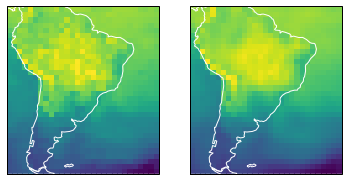

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy
print(x[0,:,6,:,:])
print(y[0,:,6,:,:])
print(output[0,:,6,:,:])
sst = y[0,0,6,:,:].cpu()
ax5 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree())
ax5.coastlines(color='white')
ax5.set_extent([-83,-25,-51.5,8])

sst = output[0,0,6,:,:].cpu()
ax5 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree())
ax5.coastlines(color='white')
ax5.set_extent([-83,-25,-51.5,8])


In [ ]:
lat = dataset.variables['lat'][:]
lon = dataset.variables['lon'][:]
# extend longitude by 2
lon_extend = np.zeros(lon.size+2)
# fill in internal values
lon_extend[1:-1] = lon # fill up with original values
# fill in extra endpoints
lon_extend[0] = lon[0]-np.diff(lon)[0]
lon_extend[-1] = lon[-1]+np.diff(lon)[-1]
# calculate the midpoints
lon_pcolormesh_midpoints = lon_extend[:-1]+0.5*(np.diff(lon_extend))

# extend latitude by 2
lat_extend = np.zeros(lat.size+2)
# fill in internal values
lat_extend[1:-1] = lat
# fill in extra endpoints
lat_extend[0] = lat[0]-np.diff(lat)[0]
lat_extend[-1] = lat[-1]+np.diff(lat)[-1]
# calculate the midpoints
lat_pcolormesh_midpoints = lat_extend[:-1]+0.5*(np.diff(lat_extend))

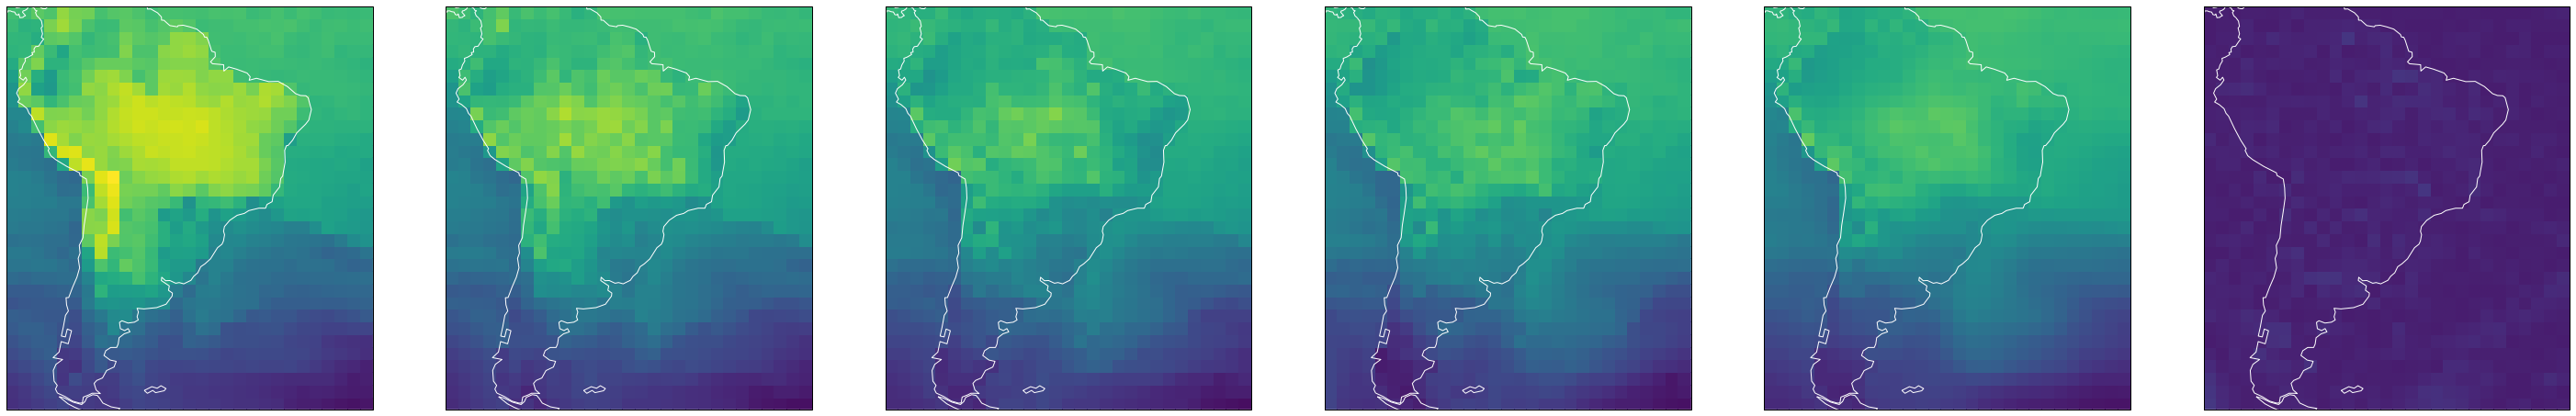

In [ ]:
total = torch.cat((x[19,0,2,:,:],x[19,0,3,:,:],x[19,0,4,:,:],ground_truth,prediction))
min_val = torch.min(total).cpu()
max_val = torch.max(total).cpu()
fig = plt.figure(figsize=(50, 50))
sst = previous_three_steps[0].cpu()
lats = dataset.variables['lat'][:]
lons = dataset.variables['lon'][:]

ax1 = plt.subplot(1, 6, 1, projection=ccrs.PlateCarree())
ax1.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax1.coastlines(color='white')
ax1.set_extent([-83,-25,-51.5,8])

sst = previous_three_steps[1].cpu()
ax2 = plt.subplot(1, 6, 2, projection=ccrs.PlateCarree())
ax2.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax2.coastlines(color='white')
ax2.set_extent([-83,-25,-51.5,8])

sst = previous_three_steps[2].cpu()
ax3 = plt.subplot(1, 6, 3, projection=ccrs.PlateCarree())
ax3.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax3.coastlines(color='white')
ax3.set_extent([-83,-25,-51.5,8])

sst = ground_truth.cpu()
ax4 = plt.subplot(1, 6, 4, projection=ccrs.PlateCarree())
ax4.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax4.coastlines(color='white')
ax4.set_extent([-83,-25,-51.5,8])

sst = prediction.cpu()
ax5 = plt.subplot(1, 6, 5, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax5.coastlines(color='white')
ax5.set_extent([-83,-25,-51.5,8])
fig.tight_layout()

sst = abs(ground_truth-prediction).cpu()
ax5 = plt.subplot(1, 6, 6, projection=ccrs.PlateCarree())
ax5.pcolormesh(lon_pcolormesh_midpoints, lat_pcolormesh_midpoints, sst,
             transform=ccrs.PlateCarree(), vmin=min_val, vmax=max_val)
ax5.coastlines(color='white')
ax5.set_extent([-83,-25,-51.5,8])
fig.tight_layout()
plt.show()
#plt.savefig('foo.pdf')

In [ ]:
class RMSELoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [ ]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import numpy as np

criterion_mae = torch.nn.L1Loss()
criterion_rmse = RMSELoss()
def report_regression_results(y_true, y_pred):
    # Print multiple regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    adjusted_r2 =  1.0 - ( mse / y_true.var() )
    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('Adjusted r2: ', round(adjusted_r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    # save a plot with the residuals
    plt.scatter(y_pred,(y_true - y_pred),edgecolors='black')
    plt.title('Fitted vs. residuals plot')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()
    f.savefig("report-experiment1.pdf", bbox_inches='tight')
    
def report_explained_variance(y_true, y_pred):
    batch, ch, lat, lon = y_true.shape
    explained_variance = 0
    for i in range(batch):
        explained_variance += metrics.explained_variance_score(y_true[i,0,:,:], y_pred[i,0,:,:])
    return explained_variance / (batch)

def report_r2(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    mse = metrics.mean_squared_error(y_true, y_pred) 
    r2 = metrics.r2_score(y_true, y_pred)
    ar2 =  1.0 - ( mse / y_true.var() )
    return r2, ar2

def report_losses(y_true, y_pred):
    mae = criterion_mae(y_true, y_pred)
    rmse = criterion_rmse(y_true, y_pred)
    return mae, rmse

def report_metrics(y_true, y_pred, removed):
    batch, ch, time, lat, lon = y_true.shape
    r2 = 0.0
    ar2 = 0.0
    mae = 0.0
    rmse = 0.0
    for i in range(batch):
        v1,v2 = report_r2(y_true[i,0,removed[i],:,:], y_pred[i,0,removed[i],:,:])
        r2 += v1
        ar2 += v2
        v1, v2 = report_losses(y_true[i,0,removed[i],:,:], y_pred[i,0,removed[i],:,:])
        mae += v1
        rmse += v2
    r2 = r2/(batch)
    ar2 = ar2/(batch)
    mae = mae/batch
    rmse = rmse/batch
    return mae, rmse, r2, ar2

def plot_residual_fitted(y_true, y_pred):
    plt.scatter(y_pred,(y_true - y_pred), alpha=0.5)
    plt.title('STConvS2S')
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.show()

In [ ]:
def init_hidden(batch_size, hidden_size, device):
		h = torch.zeros(batch_size,hidden_size, device=device)
		return (h,h)

In [ ]:
model, optimizer, epoch, loss = trainer.load_model()
batch_test_loss_mae = 0.0
batch_test_loss_rmse = 0.0
batch_explained_variance = 0.0
batch_r2 = 0.0
batch_ar2 = 0.0
model.eval()
y_true = None
with torch.no_grad():
    for i, (x, y, removed) in enumerate(test_loader):
        x,y,removed = x.to(device), y.to(device), removed.to(device)
        states_fwd = init_hidden(x.size()[0], x.size()[3]*x.size()[4], device)
        states_bckwd = init_hidden(x.size()[0], x.size()[3]*x.size()[4], device)
        output = model(x, states_fwd, states_bckwd, removed)
        loss_mae, loss_rmse, r2, ar2 = report_metrics(y, output, removed)
        if (i == 0):
            plot_residual_fitted(y[0,0,removed[i],:,:].cpu(), output[0,0,removed[i],:,:].cpu())
        batch_test_loss_mae += loss_mae.detach().item()
        batch_test_loss_rmse += loss_rmse.detach().item()
        batch_r2 += r2
        batch_ar2 += ar2
        
test_loss_mae = batch_test_loss_mae/len(test_loader)
test_loss_rmse = batch_test_loss_rmse/len(test_loader)
explained_variance = batch_explained_variance/len(test_loader)
r2 = batch_r2/len(test_loader)
ar2 = batch_ar2/len(test_loader)
print(f'MAE: {test_loss_mae:.4f}')
print(f'RMSE: {test_loss_rmse:.4f}')
print('Explained variance: ', round(explained_variance,4))
print('r2: ', round(r2,4))
print('ar2: ', round(ar2,4))

In [ ]:
def init_hidden(batch_size, hidden_size):
    h = torch.zeros(batch_size,hidden_size, device=device)
    return (h,h)
states = init_hidden(25, 32*32)
trainer.path = '../../../models/CFSR/1_step/STTSModel_3D_m05d09-h17m42s24.pth.tar'
model, optimizer, epoch, loss = trainer.load_model()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)
print(summary(model, torch.zeros((25, 1, 5, 32, 32)).to(device), states, show_input=True))

FileNotFoundError: ignored